In [217]:
import numpy as np
from matplotlib import pyplot as plt

## Simulates the 3DoF (Body Axes) dynamics of a rigid body
Input parameters:
- **Fx**: Force in the body x-direction (N)
- **Fz**: Force in the body z-direction (N)
- **My**: Moment about the body y-axis (Nm)
- **u0**: Initial velocity in the body x-direction (m/s)
- **w0**: Initial velocity in the body z-direction (m/s)
- **theta0**: Initial pitch angle (rad)
- **q0**: Initial pitch angular rate (rad/s)
- **alpha0**: Initial angle of attack (rad)
- **pos0**: Initial position in the flat Earth frame (m, m)
- **mass**: Initial mass (kg)
- **mass_e**: Empty mass (kg)
- **mass_f**: Full mass (kg)
- **Iyy_e**: Empty moment of inertia about the y-axis (kg·m²)
- **Iyy_f**: Full moment of inertia about the y-axis (kg·m²)
- **g**: Acceleration due to gravity (m/s²)
- **include_inertial_acceleration**: Whether to include inertial acceleration output

Output return values:
- **theta**: Pitch attitude (rad)
- **q**: Pitch angular rate (rad/s)
- **dqdt**: Pitch angular acceleration (rad/s²)
- **pos**: Position in the flat Earth frame (m, m)
- **velocity**: Velocity in the body frame (m/s, m/s)
- **acceleration**: Acceleration in the body frame (m/s², m/s²)
- **inertial_acceleration**: Acceleration in the inertial frame (m/s², m/s²) [if include_inertial_acceleration is True]

In [218]:
def three_dof_body_axes(
    Fx, Fz, My, 
    u0=100.0, w0=0.0, theta0=0.0, q0=0.0, alpha0=0.0, pos0=(0.0, 0.0),
    mass=0.543, mass_e=0.432, mass_f=0.543, Iyy_e=0.028, Iyy_f=0.048,
    g=0, dt=0.1, include_inertial_acceleration=False
):

    # calculate pitch angular acceleration
    Iyy = mass * Iyy_f / mass + Iyy_f
    dqdt = My / Iyy
    
    # update pitch angular rate
    q = q0 + dqdt * dt
    
    # update pitch angle
    theta = theta0 + q * dt
    
    # calculating linear accelerations
    Ax = Fx / mass
    Az = Fz / mass
    
    # update velocities
    u = u0 + Ax * dt
    w = w0 + Az * dt
    
    # update position
    x, z = pos0
    x += u * np.cos(theta) - w * dt * np.sin(theta)
    z += u * np.sin(theta) + w * dt * np.cos(theta)
    
    pos = (x, z)
    velocity = (u, w)
    acceleration = (Ax, Az)
    
    if include_inertial_acceleration:
        A_xe = Ax - g * np.sin(theta)
        A_ze = Az - g * np.cos(theta)
        inertial_acceleration = (A_xe, A_ze)

        return theta, q, dqdt, pos, velocity, acceleration, inertial_acceleration
    
    return theta, q, dqdt, pos, velocity, acceleration

## Step function
Input parameters:
- **time**: The current time (s)
- **step_time**: The time at which the step occurs (s)
- **initial_value**: The value of the output before the step time (float)
- **final_value**: The value of the output after the step time (float)
- **sample_time**: The time interval between samples (s)
- **delay**: The delay before the step occurs (s)

Output return values:
- The value of the step signal at the given time (float)

In [219]:
def step_function(time, step_time=0.0, initial_value=0.0, final_value=15.0, sample_time=0.1, delay=0.0, duration=2.0):
    effective_step_time = step_time + delay
    if effective_step_time <= time < effective_step_time + duration:
        return final_value
    else:
        return initial_value

In [220]:
# time points
time_values = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]

# generate step signal for each time point
step_signal = [step_function(t) for t in time_values]
print(step_signal)

[15.0, 15.0, 15.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [221]:
theta, q, dqdt, pos, velocity, acceleration = three_dof_body_axes(Fx=0, Fz=50, My=0)

Xe, Ze = pos
print(f"X position: {Xe}, Z position: {Ze}")

X position: 100.0, Z position: 0.9208103130755063


## Simulating the rocket

In [222]:
# lists for results
theta_list = []
q_list = []
dqdt_list = []
pos_list = []
velocity_list = []
acceleration_list = []

In [223]:
# step function parameters
start_time = 0.0
end_time = 10.0
time_step = 0.1
final_value = 15.0 # 15N of thrust
times = np.arange(start_time, end_time + time_step, time_step)

In [224]:
# initial conditions
Fx = 0 # assuming no force in x-direction
My = 0 # assuming no moment about the y-axis
u0 = 0.0
w0 = 0.0
theta0 = 0.0
q0 = 0.0
alpha0 = 0.0
pos0 = (0.0, 0.0)
mass = 0.543
mass_e = 0.432
mass_f = 0.543
Iyy_e = 0.028
Iyy_f = 0.048
g = 9.81
include_inertial_acceleration = False

In [225]:
# calculate dynamics at each time point
for t in times:
    Fz = step_function(t, final_value=final_value) * -(g)
    theta, q, dqdt, pos, velocity, acceleration = three_dof_body_axes(
        Fx, Fz, My,
        u0, w0, theta0, q0, alpha0, pos0,
        mass, mass_e, mass_f, Iyy_e, Iyy_f, g, include_inertial_acceleration
    )

    u0, w0 = velocity
    theta0, q0 = theta, q
    pos0 = pos

    # Xe, Ze = pos
    # Ze_inv = Ze * -1.0

    theta_list.append(theta)
    q_list.append(q)
    dqdt_list.append(dqdt)
    pos_list.append(pos)
    velocity_list.append(velocity)
    acceleration_list.append(acceleration)

print(pos_list)
print(velocity_list)

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.

  _____            _        _      _____ _           
 |  __ \          | |      | |    / ____(_)          
 | |__) |___   ___| | _____| |_  | (___  _ _ __ ___  
 |  _  // _ \ / __| |/ / _ \ __|  \___ \| | '_ ` _ \ 
 | | \ \ (_) | (__|   <  __/ |_   ____) | | | | | | |
 |_|  \_\___/ \___|_|\_\___|\__| |_____/|_|_| |_| |_|


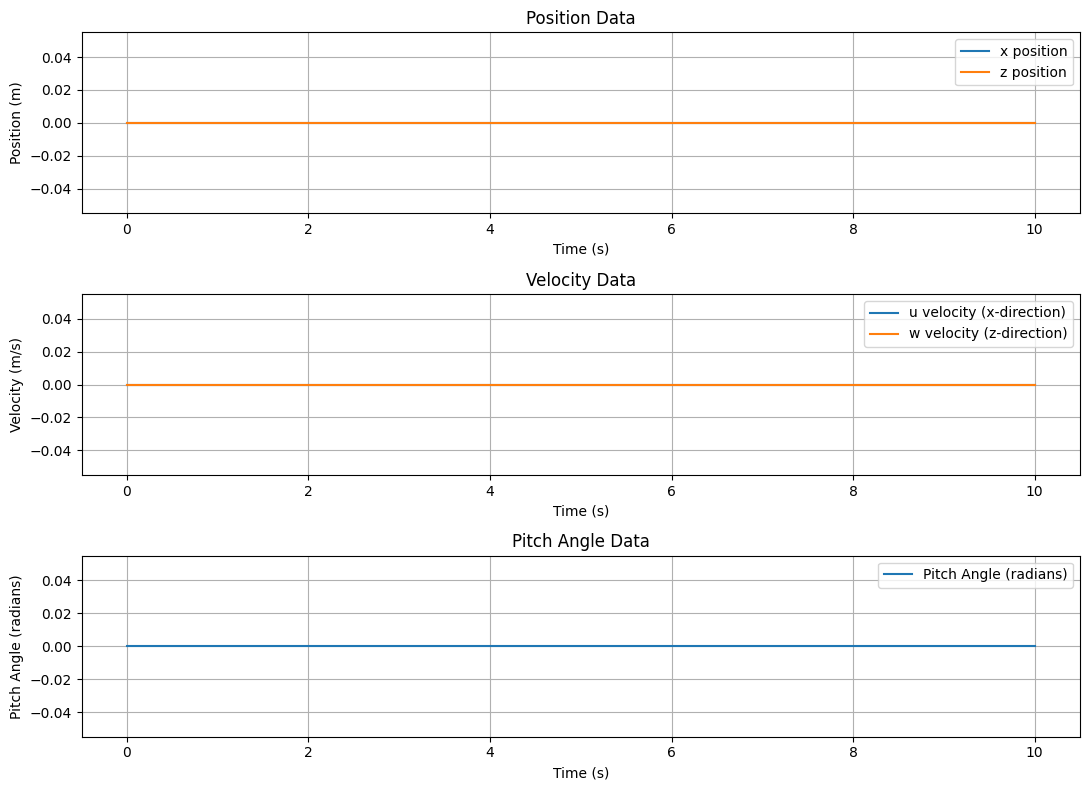

In [226]:
# plot output data
print('  _____            _        _      _____ _           ')
print(' |  __ \          | |      | |    / ____(_)          ')
print(' | |__) |___   ___| | _____| |_  | (___  _ _ __ ___  ')
print(' |  _  // _ \ / __| |/ / _ \ __|  \___ \| | \'_ ` _ \ ')
print(' | | \ \ (_) | (__|   <  __/ |_   ____) | | | | | | |')
print(' |_|  \_\___/ \___|_|\_\___|\__| |_____/|_|_| |_| |_|')

plt.figure(figsize=(11, 8))

plt.subplot(3, 1, 1)
plt.plot(times, [pos[0] for pos in pos_list], label='x position')
plt.plot(times, [pos[1] for pos in pos_list], label='z position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.title('Position Data')

plt.subplot(3, 1, 2)
plt.plot(times, [velocity[0] for velocity in velocity_list], label='u velocity (x-direction)')
plt.plot(times, [velocity[1] for velocity in velocity_list], label='w velocity (z-direction)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid()
plt.title('Velocity Data')

plt.subplot(3, 1, 3)
plt.plot(times, theta_list, label='Pitch Angle (radians)')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (radians)')
plt.legend()
plt.grid()
plt.title('Pitch Angle Data')

plt.tight_layout()
plt.show()